# HDP-HMM
direct assignment - similar to collapsed gibbs sampler in gmm

In [1]:
# init things
from sklearn.cluster import KMeans
from scipy.stats import wishart, dirichlet, invwishart, multivariate_normal, beta, multivariate_t, multinomial
from sklearn.metrics.cluster import adjusted_rand_score as ari
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
import numpy as np
import plot_hmm
import numba_functions
from numpy.random import binomial
import matplotlib.pyplot as plt
from scipy.special import gammaln

In [2]:
import pickle

# Load state sequence and data from the pickle file
with open('hmm_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Access the loaded data
loaded_ss = loaded_data['state_sequence']
loaded_data = loaded_data['data']
import plot_hmm

In [34]:
# define keys to use

# GIW
M0 = "m0"
K0 = "k0"
NU0 = "nu0"
S0 = "S0"

# SBP
BETA_VEC = "beta"
BETA_NEW = "beta_new"
GAMMA0 = "gamma0"
ALPHA0 = "alpha0"
KAPPA0 = "kappa0"
RHO0 = "rho0"

# Aux vars for SBP
M_MAT = "m_mat"             # number of tables in restaurant j that were served dish k
M_INIT = "m_init"
W_VEC = "w_vec"             # override variable for table t in restaurant j
M_MAT_BAR = "m_mat_bar"

# Sufficient statistics
NK = "nk"
N_MAT = "n_mat"
N_FT = "n_ft"

# Convergence
ARI = 'ari'
LL = 'll'
MU_TRACE = 'mu_trace'
SIGMA_TRACE = 'sigma_trace'
PIE_TRACE = "pie_trace"
A_TRACE = "A_trace"

init ari 0.458


/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


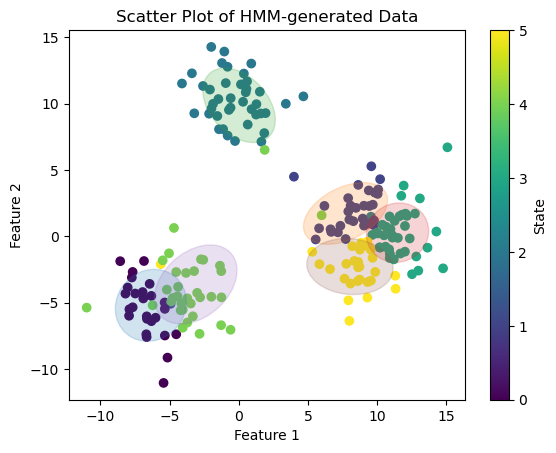

new state
new state
new state
deleting component(s),  [7]
new state
deleting component(s),  [6]
deleting component(s),  [6]
iter:  2    ARI:  0.711       ll:  -1026.6824717136253     K:  7
deleting component(s),  [5]
iter:  3    ARI:  0.751       ll:  -1024.1597483072633     K:  6
deleting component(s),  [5]
iter:  4    ARI:  0.687       ll:  -1034.8564812579773     K:  5
iter:  5    ARI:  0.65       ll:  -1039.0277287589943     K:  5
new state
new state
new state
iter:  6    ARI:  0.613       ll:  -1055.9822040105214     K:  8
deleting component(s),  [5]
new state
iter:  7    ARI:  0.692       ll:  -1040.3094992015574     K:  8
deleting component(s),  [5]
deleting component(s),  [5]
deleting component(s),  [5]
iter:  8    ARI:  0.708       ll:  -1035.0373577897515     K:  5
deleting component(s),  [4]
iter:  9    ARI:  0.759       ll:  -1013.00935847923     K:  4
iter:  10    ARI:  0.782       ll:  -1024.5022841129764     K:  4
new state
new state
iter:  11    ARI:  0.743       ll:  -

In [67]:
import math
from hmmlearn.hmm import GaussianHMM

class InfiniteDirectSamplerHMM():
    def __init__(self, X, K, Z_true, burn_in=1, iterations=20):
        """
        [] input
        X = data n x d
        K = expected amount of states

        [] params = beta, pi, z, mu, Sigma
        beta ~ GEM(gamma)
        pi ~ DP(beta, k, alpha)
        z ~ HDP()
        mu ~ Gauss(m0, V0)
        Sigma ~ IW(nu0, S0)

        [] hyper-params:
        gamma - concentration for GEM
        alpha - concentration for 2nd GEM
        k - sticky-ness of A

        m0 -> mean of init assignments
        V0 -> large eye matrix
        nu0 -> K + 1
        S0 -> data scatter matrix

        [] ss - need to update probably
        nk - count of data in each k
        x_bar - mean of data in each k
        """

        self.X = X  # data n x d
        self.K = K  # current number of states
        self.burn_in = burn_in
        self.iterations = iterations
        self.N = X.shape[0]     # length of data
        self.D = X.shape[1]     # dimension of data
        self.Z = None
        self.Z_true = Z_true
        self.hmm = GaussianHMM(n_components=self.K, covariance_type="full")
        self.tol = 1e-2

        # GIW
        self.giw = {
            M0: None,
            K0: None,
            NU0: None,
            S0: None,
        }

        # SBP vars and hp
        self.sbp = {
            BETA_VEC: None,
            BETA_NEW: None,
            ALPHA0: None,
            GAMMA0: None,
            KAPPA0: None,
            RHO0: None,
        }

        self.aux = {
            M_MAT: None,
            M_INIT: None,
            W_VEC: None,
            M_MAT_BAR: None,
        }

        # Update this to include mean and sums at some point
        self.ss = {
            NK: None,
            N_MAT: None,
            N_FT: None,
        }

        self.track = {
            ARI: np.zeros(self.iterations),
            LL: [],
            MU_TRACE: [],
            SIGMA_TRACE: [],
            A_TRACE: [],
            PIE_TRACE: []
        }

        self.init_sbp()
        self.init_z()
        self.init_giw_and_aux()
        self.update_ss(True)

    def init_sbp(self):

        self.sbp[GAMMA0] = 2           # init gem
        self.sbp[KAPPA0] = 0.5          # sticky-ness
        self.sbp[ALPHA0] = 100          # concentration for 2nd stick breaking
        self.sbp[RHO0]= 0.5             # self.kappa0/(self.kappa0+self.sbp[ALPHA0])

        # inits beta vec
        beta_vec = dirichlet.rvs(np.array([1, self.sbp[GAMMA0]]), size=1)[0]
        beta_new = beta_vec[-1]
        beta_vec = beta_vec[:-1]

        for k in range(self.K - 1):
            b = beta.rvs(1, self.sbp[GAMMA0], size=1)
            beta_vec = np.hstack((beta_vec, b*beta_new))
            beta_new = (1-b)*beta_new

        self.sbp[BETA_VEC] = beta_vec
        self.sbp[BETA_NEW] = beta_new

    def init_z(self):

        self.Z = np.zeros(self.N)

        # true means
        kmeans = KMeans(n_clusters=self.K, random_state=42)
        kmeans.fit(self.X)

        # shuffle labels
        num_labels_to_replace = int(0.05 * len(kmeans.labels_))
        # Generate random labels between 0 and k
        random_labels = np.random.randint(0, self.K, num_labels_to_replace)
        # Replace 10% of the labels with random numbers
        shuffled_labels = np.copy(kmeans.labels_)
        replace_indices = np.random.choice(len(shuffled_labels), num_labels_to_replace, replace=False)
        shuffled_labels[replace_indices] = random_labels
        # Assign the shuffled labels to self.Z
        self.Z = shuffled_labels
        print('init ari', np.round(ari(self.Z_true, self.Z), 3))

    def init_giw_and_aux(self):

        sig_bar = np.cov(self.X.T, bias=True)
        diagsig = np.diag(np.diag(sig_bar))
        self.giw[M0] = np.mean(self.X, axis = 0)
        self.giw[K0] = 1
        self.giw[S0] = np.eye(self.D, self.D) * 100 # diagsig   #
        self.giw[NU0] = np.copy(self.D) + 2  # 1 Degrees of freedom IW, nu0 + 2 will mean <sigma> = S0

        self.aux[M_MAT] = np.zeros((self.K,self.K))
        self.aux[M_MAT_BAR] = np.zeros((self.K,self.K))
        self.aux[W_VEC] = np.zeros(self.K)

    def update_ss(self, initialising=False):
        # NK: None,
        # N_MAT: None,
        # N_FT: None,
        nk = np.zeros(self.K)
        for k in range(self.K):
            nk[k] = np.sum(self.Z == k)

        n_mat = np.zeros((self.K, self.K))
        for i in range(self.K):
            # find indices of states that come right after state i
            indices = np.where(self.Z == i)[0] + 1  # indices of X_k

            # need to address the case for the last state in the sequence
            if self.N in indices:
                indices = np.delete(indices, np.where(indices == self.N))

            states = self.Z[indices]
            n_i = np.zeros(self.K)
            for j in range(self.K):
                n_i[j] = np.count_nonzero(states == j)
            n_mat[i,:] = n_i

        # n_ft
        n_ft = np.zeros((self.K))
        n_ft[int(self.Z[0])] += 1

        if not initialising:
            if np.all(self.ss[NK] == nk) != True:
                print('warning self.nk == nk) != True:')

            if np.all(self.ss[N_MAT] == n_mat) != True:
                print('warning self.nk == nk) != True:')

            if np.all(self.ss[N_FT] == n_ft) != True:
                print('warning self.nk == nk) != True:')


        self.ss[NK] = nk
        self.ss[N_MAT] = n_mat
        self.ss[N_FT] = n_ft

        if initialising:
            mu, sigma = self.get_map_gauss_params()

            plot_hmm.plot_hmm_data(loaded_data, self.Z, self.K, mu, sigma)

    def _multivariate_students_t(self, x, mu, shape, v):

        delta = x - mu
        v = int(v)

        logdet_covar = np.linalg.slogdet(shape)[1]
        inv_covar = np.linalg.inv(shape)
        try:
            return_value = gammaln((v + self.D) / 2) - gammaln((v) / 2) - self.D/2.*np.log(v) - self.D/2.*np.log(np.pi) - logdet_covar/2 - \
             (v + self.D)/2. * math.log(1 + 1./v * np.dot(np.dot(delta, inv_covar), delta))
        except Exception as e:
            print('_multivariate_students_t', e)
            shape = self.ensure_symmetric_positive_semidefinite(shape)

            delta = x - mu
            v = int(v)

            logdet_covar = np.linalg.slogdet(shape)[1]
            inv_covar = np.linalg.inv(shape)

            return_value = gammaln((v + self.D) / 2) - gammaln((v) / 2) - self.D/2.*np.log(v) - self.D/2.*np.log(np.pi) - logdet_covar/2 - \
             (v + self.D)/2. * math.log(1 + 1./v * np.dot(np.dot(delta, inv_covar), delta))

        return return_value


    def is_symmetric_positive_semidefinite(self, matrix):
        # Check for symmetry
        if not np.all(matrix == matrix.T):
            return False

        # Check for positive semidefiniteness
        try:
            np.linalg.cholesky(matrix)
            return True
        except np.linalg.LinAlgError:
            return False

    def ensure_symmetric_positive_semidefinite(self, A):
        # Ensure symmetry
        A = (A + A.T) / 2.0

        # Ensure positive semidefiniteness
        eigvals, eigvecs = np.linalg.eigh(A)
        eigvals[eigvals < 0] = 0
        A = eigvecs @ np.diag(eigvals) @ eigvecs.T

        return A

    def student_t_giw(self, x, mt, kt, nut, St):
        loc = mt
        shape = St * (kt + 1.)/(kt*(nut - self.D + 1.))
        df = (nut - self.D + 1.)
        if self.is_symmetric_positive_semidefinite(shape) is False:
            print('matrix warning')
        return self._multivariate_students_t(x, loc, shape, df)

    def student_t_post(self, x):
        k0 = self.giw[K0]
        s0 = np.copy(self.giw[S0])
        m0 = np.copy(self.giw[M0])
        nu0 = self.giw[NU0]

        Sc = s0 + (np.outer(m0, m0) * k0)

        outer_c = np.zeros((self.N, self.D, self.D))
        for i in range(self.N):
            outer_c[i, :, :] = np.outer(self.X[i], self.X[i])

        probs = np.zeros(self.K)
        for k in range(self.K):
            if self.ss[NK][k] > 0:
                # a lot of this should be cached
                kn = k0 + self.ss[NK][k]
                nun = nu0 + self.ss[NK][k]
                mc = (k0 * m0) / kn

                # calculate Sx
                Sx = np.sum(outer_c[self.Z == k], axis=0)

                # mn
                # mn_top_a = (self.nk[k] * self.x_bar[k])
                mn_top_b = np.sum(self.X[self.Z == k], axis = 0)
                mn = mc + mn_top_b / kn

                # Sn
                Sn = Sc + Sx - (np.outer(mn, mn) * kn)

                prob_k = self.student_t_giw(x, mn, kn, nun, Sn)
                if(prob_k > 0):
                    print('warning')
                probs[k] = prob_k
            else:
                probs[k] = self.student_t_giw(x, self.giw[M0], self.giw[K0], self.giw[NU0], self.giw[S0])

        x_dist_new = self.student_t_giw(x, self.giw[M0], self.giw[K0], self.giw[NU0], self.giw[S0])
        return probs, x_dist_new

    def get_crf_prob(self, t):

        # define vars for easy reading and avoid changing
        alpha0 = self.sbp[ALPHA0]
        rho0 = self.sbp[RHO0]
        beta_vec = np.copy(self.sbp[BETA_VEC])
        beta_new = self.sbp[BETA_NEW]
        n_mat = np.copy(self.ss[N_MAT])

        tmp_vec = np.arange(self.K)
        j = self.Z[t-1]

        if t < self.N - 1:

            l = self.Z[t+1]

            zt_dist = \
                (alpha0*beta_vec + n_mat[j]+rho0*(j==tmp_vec))\
                /(alpha0 + n_mat[j].sum()+rho0)

            ztplus1_dist = \
                (alpha0*beta_vec[l] + n_mat[:,l] + rho0*(l == tmp_vec) + (j==l)*(j == tmp_vec))\
                /(alpha0 + n_mat.sum(axis=1) + rho0+(j == tmp_vec))

            new_dist = \
                (alpha0**2)*beta_vec[l]*beta_new\
                /((alpha0+rho0)*(alpha0+n_mat[j].sum()+rho0))

            return np.log(zt_dist*ztplus1_dist), np.log(new_dist)
        else:

            zt_dist = \
                (alpha0*beta_vec + n_mat[j]+rho0*(j==tmp_vec))\
                /(alpha0 +n_mat[j].sum()+rho0)

            new_dist = \
                alpha0*beta_new\
                /(alpha0+n_mat[j].sum()+rho0)

            return np.log(zt_dist), np.log(new_dist)

    def sample_z(self):

        for t in range(1, self.N):
            # remove current assignment of z_t from stats and counts

            x = self.X[t]
            self.remove_x_from_z(t, x)

            # log prob of CRF
            zt_dist, zt_dist_new = self.get_crf_prob(t)

            # log prob of x | hyper-params
            x_dist, x_dist_new = self.student_t_post(x)

            # sample z
            post_cases = np.hstack((zt_dist+x_dist, zt_dist_new+x_dist_new))
            post_cases = np.exp(post_cases) / np.sum(np.exp(post_cases))    # softmax
            try:
                self.Z[t] = np.where(np.random.multinomial(n=1, pvals=post_cases, size=1).flatten())[0][0]
            except Exception as e:
                print('failed', e)

            # new state
            if self.Z[t] == self.K:
                print('new state')
                # sampled beta
                b = beta.rvs(1, self.sbp[GAMMA0], size=1)
                self.sbp[BETA_VEC] = np.hstack((self.sbp[BETA_VEC], b*self.sbp[BETA_NEW]))
                self.sbp[BETA_NEW] = (1-b)*self.sbp[BETA_NEW]

                # update ss
                self.ss[N_MAT] = np.hstack((self.ss[N_MAT], np.zeros((self.K,1))))
                self.ss[N_MAT] = np.vstack((self.ss[N_MAT], np.zeros((1,self.K+1))))
                self.ss[N_FT] = np.hstack((self.ss[N_FT], [0]))
                self.ss[NK] = np.hstack((self.ss[NK], [0]))
                self.K += 1

            # update ss
            self.add_x_to_z(t, x)
            self.handle_empty_components()

    # remove x from z and update ss
    def remove_x_from_z(self, t, x):
        # t is current index of z
        # x is data
        zt = self.Z[t]
        j = self.Z[t-1]

        self.ss[NK][zt] -= 1
        self.ss[N_MAT][j, zt] -=1
        if t + 1 < self.N:
            l = self.Z[t+1]
            self.ss[N_MAT][zt, l] -=1

    def add_x_to_z(self, t, x):
        # t is current index of z
        # x is data
        zt = self.Z[t]
        j = self.Z[t-1]

        self.ss[NK][zt] += 1
        self.ss[N_MAT][j, zt] +=1
        if t + 1 < self.N:
            l = self.Z[t+1]
            self.ss[N_MAT][zt, l] +=1

    def handle_empty_components(self):
        nk = np.zeros(self.K)
        for k in range(self.K):
            nk[k] = np.sum(self.Z == k)
        zero_indices = np.where(nk == 0)[0]
        if len(zero_indices) > 0:
            print('deleting component(s), ', zero_indices)
            if len(zero_indices) > 1:
                print('more than 1 zero cluster')
            rem_ind = np.unique(self.Z)
            d = {k: v for v, k in enumerate(sorted(rem_ind))}
            self.Z = np.array([d[x] for x in self.Z])
            self.ss[N_MAT] = self.ss[N_MAT][rem_ind][:,rem_ind]
            self.ss[N_FT] = self.ss[N_FT][rem_ind]
            self.ss[NK] = self.ss[NK][rem_ind]
            self.sbp[BETA_VEC] = self.sbp[BETA_VEC][rem_ind]
            self.K = len(rem_ind)

    def sample_aux_vars(self):
        m_mat = np.zeros((self.K,self.K))

        for j in range(self.K):
            for k in range(self.K):
                if self.ss[N_MAT][j,k] == 0:
                    m_mat[j,k] = 0
                else:
                    # pretend multivariate to len(n_mat) at once and avoid loop
                    x_vec = binomial(1, (self.sbp[ALPHA0]*self.sbp[BETA_VEC][k]+self.sbp[RHO0]*(j==k))
                                     /(np.arange(self.ss[N_MAT][j,k])+self.sbp[ALPHA0]*self.sbp[BETA_VEC][k]+self.sbp[RHO0]*(j==k)))
                    x_vec = np.array(x_vec).reshape(-1)
                    m_mat[j,k] = sum(x_vec)
        self.aux[M_MAT] = m_mat

        w_vec = np.zeros(self.K)
        m_mat_bar = m_mat.copy()

        if self.sbp[RHO0] > 0:
            stick_ratio = self.sbp[KAPPA0]
            for j in range(self.K):
                if m_mat[j,j]>0:
                    w_vec[j] = binomial(m_mat[j,j], stick_ratio/(stick_ratio+self.sbp[BETA_VEC][j]*(1-stick_ratio)))
                    m_mat_bar[j,j] = m_mat[j,j] - w_vec[j]

        self.aux[W_VEC] = w_vec
        self.aux[M_MAT_BAR] = m_mat_bar

        # last time point
        self.aux[M_MAT_BAR][0,0] += 1
        self.aux[M_MAT][0,0] += 1

    def sample_beta(self):
        try:
            beta_vec = dirichlet.rvs(np.hstack((self.aux[M_MAT_BAR].sum(axis=0), self.sbp[GAMMA0])), size=1)[0]
        except Exception as e:
            print('sample_beta failed')

        beta_new = beta_vec[-1]
        beta_vec = beta_vec[:-1]

        self.sbp[BETA_VEC] = beta_vec
        self.sbp[BETA_NEW] = beta_new

    def get_map_gauss_params(self):
        """
        Return MAP estimate of the means and sigma, see murphy 4.215
        """
        sigmas = np.zeros((self.K, self.D, self.D))
        mus = np.zeros((self.K, self.D))

        k0 = self.giw[K0]
        s0 = np.copy(self.giw[S0])
        m0 = np.copy(self.giw[M0])
        nu0 = self.giw[NU0]

        Sc = s0 + (np.outer(m0, m0) * k0)

        outer_c = np.zeros((self.N, self.D, self.D))
        for i in range(self.N):
            outer_c[i, :, :] = np.outer(self.X[i], self.X[i])

        for k in range(self.K):

            kn = k0 + self.ss[NK][k]
            nun = nu0 + self.ss[NK][k]
            mc = (k0 * m0) / kn

            # calculate Sx
            Sx = np.sum(outer_c[self.Z == k], axis=0)

            # mn
            mn_top_b = np.sum(self.X[self.Z == k], axis = 0)
            mn = mc + mn_top_b / kn

            # Sn
            Sn = Sc + Sx - (np.outer(mn, mn) * kn)

            mus[k, :] = mn
            sigmas[k, :, :] = Sn / (nun + self.D + 2)

        return mus, sigmas

    def sample_pi(self):
        A = np.zeros((self.K,self.K))
        for k in range(self.K):
            prob_vec = np.hstack((self.sbp[ALPHA0]*self.sbp[BETA_VEC]+self.ss[N_MAT][k]))
            prob_vec[k] += self.sbp[RHO0]
            prob_vec[prob_vec<0.01] = 0.01
            A[k, :] = dirichlet.rvs(prob_vec, size=1)[0]

        prob_vec = self.sbp[ALPHA0]*self.sbp[BETA_VEC] + self.ss[N_FT]
        prob_vec[prob_vec<0.01] = 0.01
        pie = dirichlet.rvs(prob_vec, size=1)[0]
        return A, pie

    def get_hmm(self):
        # create hmm from most recent params
        sigma = self.track[SIGMA_TRACE][-1]
        mu = self.track[MU_TRACE][-1]
        pie = self.track[PIE_TRACE][-1]
        A = self.track[A_TRACE][-1]

        hmm_updated = GaussianHMM(self.K, covariance_type='full')
        hmm_updated.n_features, hmm_updated.covars_, hmm_updated.means_, hmm_updated.startprob_, hmm_updated.transmat_ = \
            self.D, sigma, mu, pie, A

        self.hmm = hmm_updated
        return self.hmm

    def get_likelihood(self):
        # likelihood of hmm, update hmmlearn object and using it for simplicity
        return self.hmm.score(self.X)

    def gibbs_sweep(self):
        self.sample_z()
        self.sample_aux_vars()
        self.sample_beta()
        self.update_ss()
        # sample hyper-params

    def fit(self):

        for it in range(self.iterations):

            self.gibbs_sweep()

            # collect samples
            A, pie = self.sample_pi()
            mus, sigma = self.get_map_gauss_params()

            self.track[MU_TRACE].append(mus)
            self.track[SIGMA_TRACE].append(sigma)
            self.track[A_TRACE].append(A)
            self.track[PIE_TRACE].append(pie)
            _ = self.get_hmm()
            self.track[LL].append(self.get_likelihood())

            if it > self.burn_in:

                # Calculate ARI
                if self.Z_true is not None:
                    self.track[ARI][it] = np.round(ari(self.Z_true, self.Z), 3)
                    print('iter: ', it, '   ARI: ', self.track[ARI][it], '      ll: ', self.track[LL][it], '    K: ', self.K)

                    if self.track[ARI][it] >= 0.98 and np.abs(self.track[LL][it] - self.track[LL][it-1]) < self.tol:
                        print('ARI has reached 1 complete')
                        break

        print('completed iterations')
        A, pie = self.sample_pi()
        mus, sigmas = self.get_map_gauss_params()
        return A, pie, mus, sigmas

my_hmm = InfiniteDirectSamplerHMM(loaded_data, 6, loaded_ss, iterations=40) # start with 5 states
fit_vars = my_hmm.fit()

/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


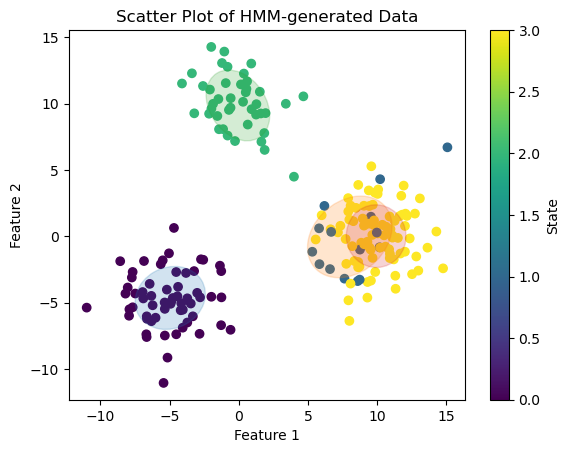

In [68]:
plot_hmm.plot_hmm_data(loaded_data, my_hmm.Z, my_hmm.K, fit_vars[2], fit_vars[3])

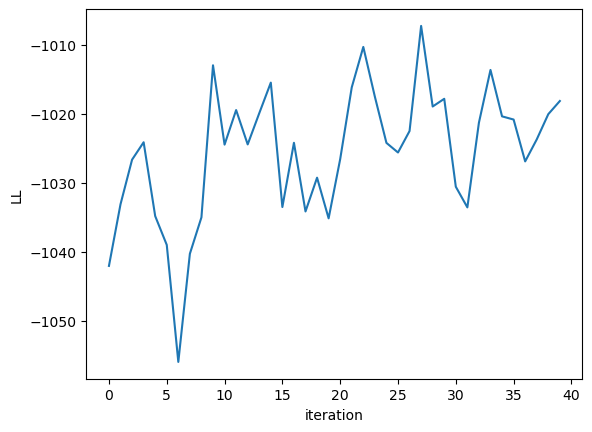

In [69]:
# plt.plot(range(0,len(my_hmm.track[ARI])), my_hmm.track[ARI], marker="None")
plt.plot(range(0,len(my_hmm.track[LL])), my_hmm.track[LL], marker="None")
plt.xlabel('iteration')
plt.ylabel('LL')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()